In [1]:
from __future__ import division

import json
from glob import glob
from tqdm import tqdm
import sys, os
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
from scipy import stats
import itertools
import warnings
from collections import OrderedDict 
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn

#plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
sys.path.append("utils/")
import utils as utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Plotting style
sc.settings.set_figure_params(dpi=120, fontsize=10, dpi_save=300, frameon=False, format='pdf')
sc.settings.verbosity = 0
sns.set_style(style="white")
sns.set_style("ticks")

**Define new cmap by truncating extreme colors, so the extremes are not so dark**

In [6]:
cmap = plt.get_cmap('RdYlBu_r')
new_cmap = utils.truncate_colormap(cmap, 0.1, 0.9)

# Load data

In [7]:
adata = sc.read_h5ad("data/IP.proc.myeloid.h5ad")

# created a scaled layer
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

**define cluster colors and set order**

In [8]:
cluster_colors = {k:v for k,v in zip(adata.obs['combined_clusters'].cat.categories, adata.uns['combined_clusters_colors'])}
cluster_colors

{'I4': '#029e73',
 'I3': '#d55e00',
 'I2': '#0173b2',
 'I1': '#de8f05',
 'M4': 'tab:purple',
 'M3': '#949494',
 'M2': '#ece133',
 'M1': '#cc78bc',
 'A2': '#56b4e9',
 'A1': '#fbafe4',
 'A3': '#ca9161'}

In [9]:
new_order_clusters = ['A1', 'A2', 'A3', 'I1', 'I2', 'I3', 'I4', 'M1', 'M2', 'M3', 'M4'][::-1]

adata.obs['combined_clusters'] = adata.obs['combined_clusters'].cat.reorder_categories(new_order_clusters)
adata.uns['combined_clusters_colors'] = [cluster_colors[el] for el in new_order_clusters]

adata.obs['treatment'] = adata.obs['treatment'].cat.reorder_categories(['control', 'N2_systemic'])


**markers**

In [10]:
with open("data/IP_markers.json") as json_file:
    markers = json.load(json_file)

# Figure 2a

/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


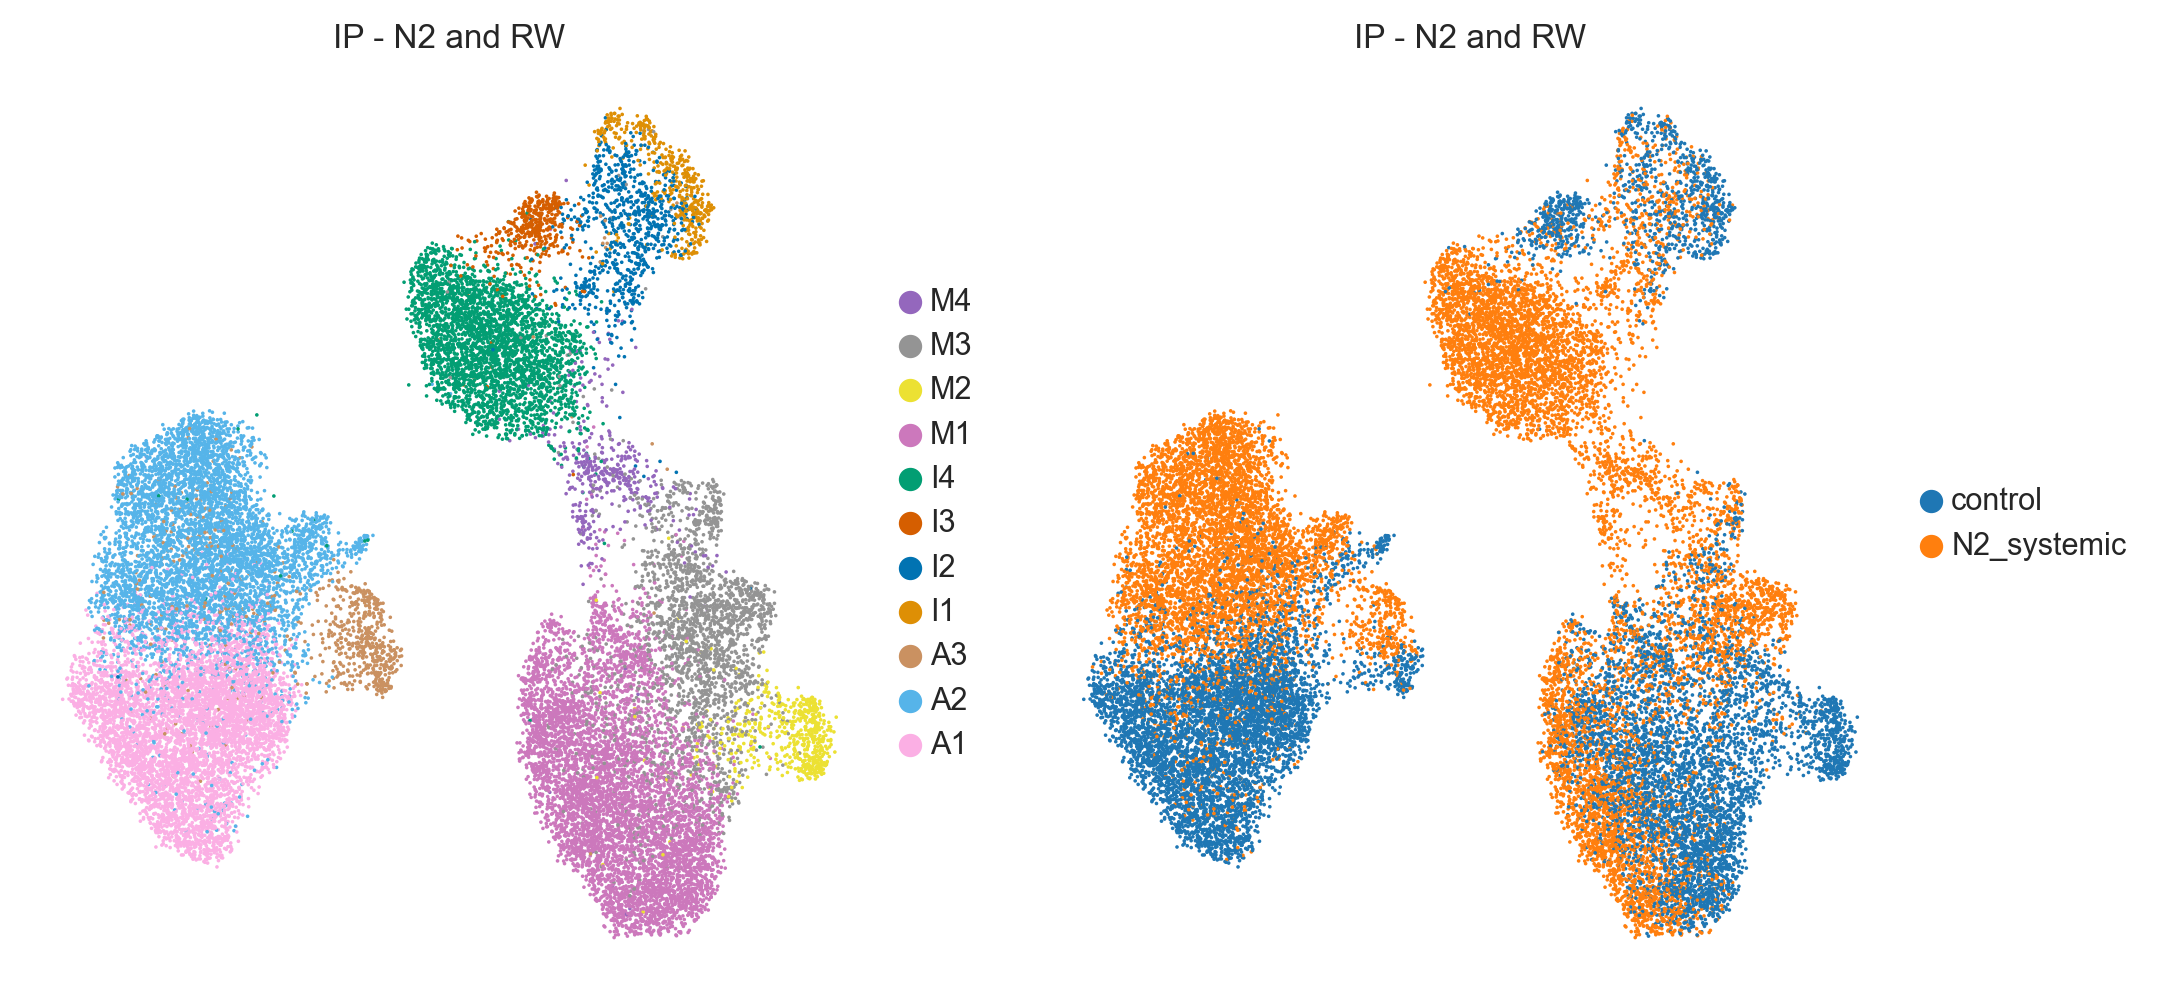

In [11]:
with plt.rc_context({"figure.figsize": (5, 4)}):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sc.pl.umap(adata, color='combined_clusters', title='IP - N2 and RW', show=False, ax=ax1)
    sc.pl.umap(adata, color='treatment', title='IP - N2 and RW', show=False, ax=ax2)

# Figure 2b

In [12]:
clusters = {
    'M':['M1', 'M2', 'M3', 'M4'],
    'I':['I1', 'I2', 'I3', 'I4'],
    'A':['A1', 'A2', 'A3']
}

colors = {}
for el in clusters:
    colors[el] = adata[adata.obs['combined_clusters'].isin(clusters[el])].uns['combined_clusters_colors']

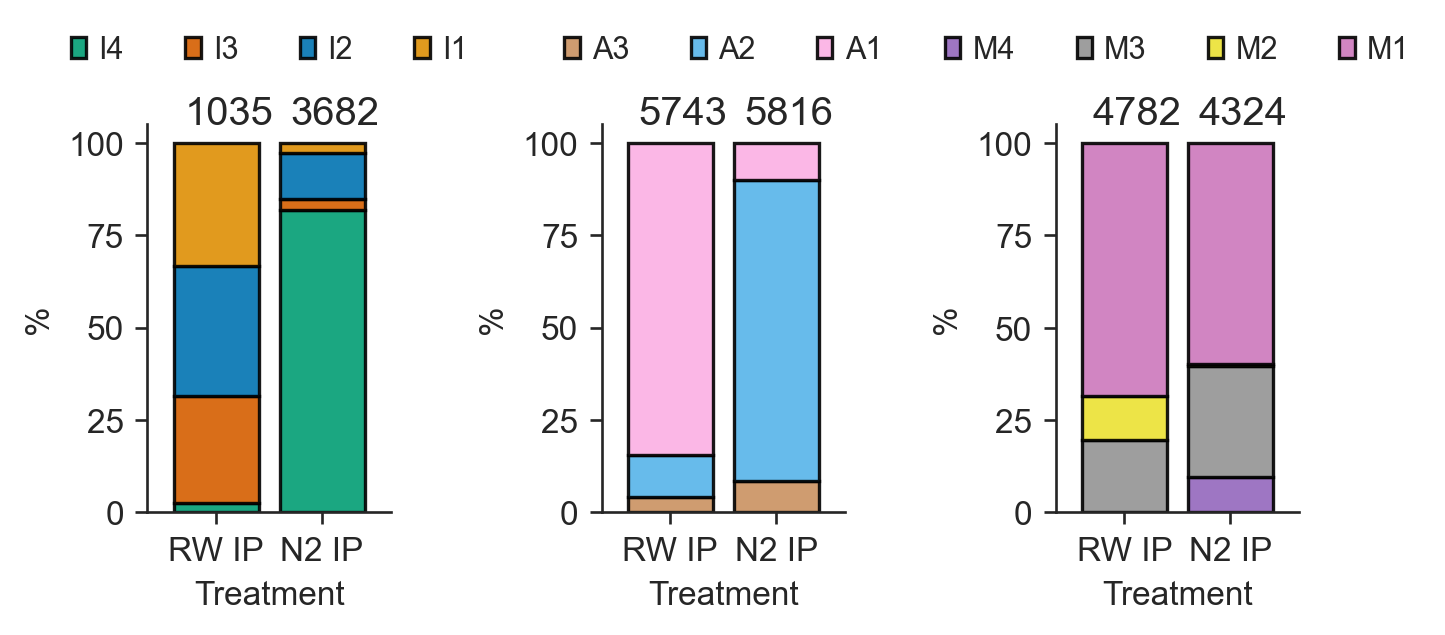

In [13]:
with plt.rc_context({ "font.size" : 12}):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(6, 3))

    utils.plotbarcomplete(adata[adata.obs['combined_clusters'].isin(clusters['I'])].obs, 'treatment', 'combined_clusters',
                    colors['I'].tolist(), ax1,  order=['control', 'N2_systemic'], kind='bar')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=10, frameon=False, )
    ax1.set_xticklabels(['RW IP', 'N2 IP'], rotation=0)
    ax1.set_ylabel('%')
    ax1.set_xlabel('Treatment')
    
    utils.plotbarcomplete(adata[adata.obs['combined_clusters'].isin(clusters['A'])].obs, 'treatment', 'combined_clusters', 
                    colors['A'].tolist(), ax2,  order=['control', 'N2_systemic'], kind='bar')
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=10, frameon=False, )
    ax2.set_xticklabels(['RW IP', 'N2 IP'], rotation=0)
    ax2.set_ylabel('%')
    ax2.set_xlabel('Treatment')
    
    utils.plotbarcomplete(adata[adata.obs['combined_clusters'].isin(clusters['M'])].obs, 'treatment', 'combined_clusters',
                    colors['M'].tolist(), ax3,  order=['control', 'N2_systemic'], kind='bar')
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=10, frameon=False, )
    ax3.set_xticklabels(['RW IP', 'N2 IP'], rotation=0)
    ax3.set_ylabel('%')
    ax3.set_xlabel('Treatment')
    
    plt.tight_layout()

# Supplemental figure 2d

/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


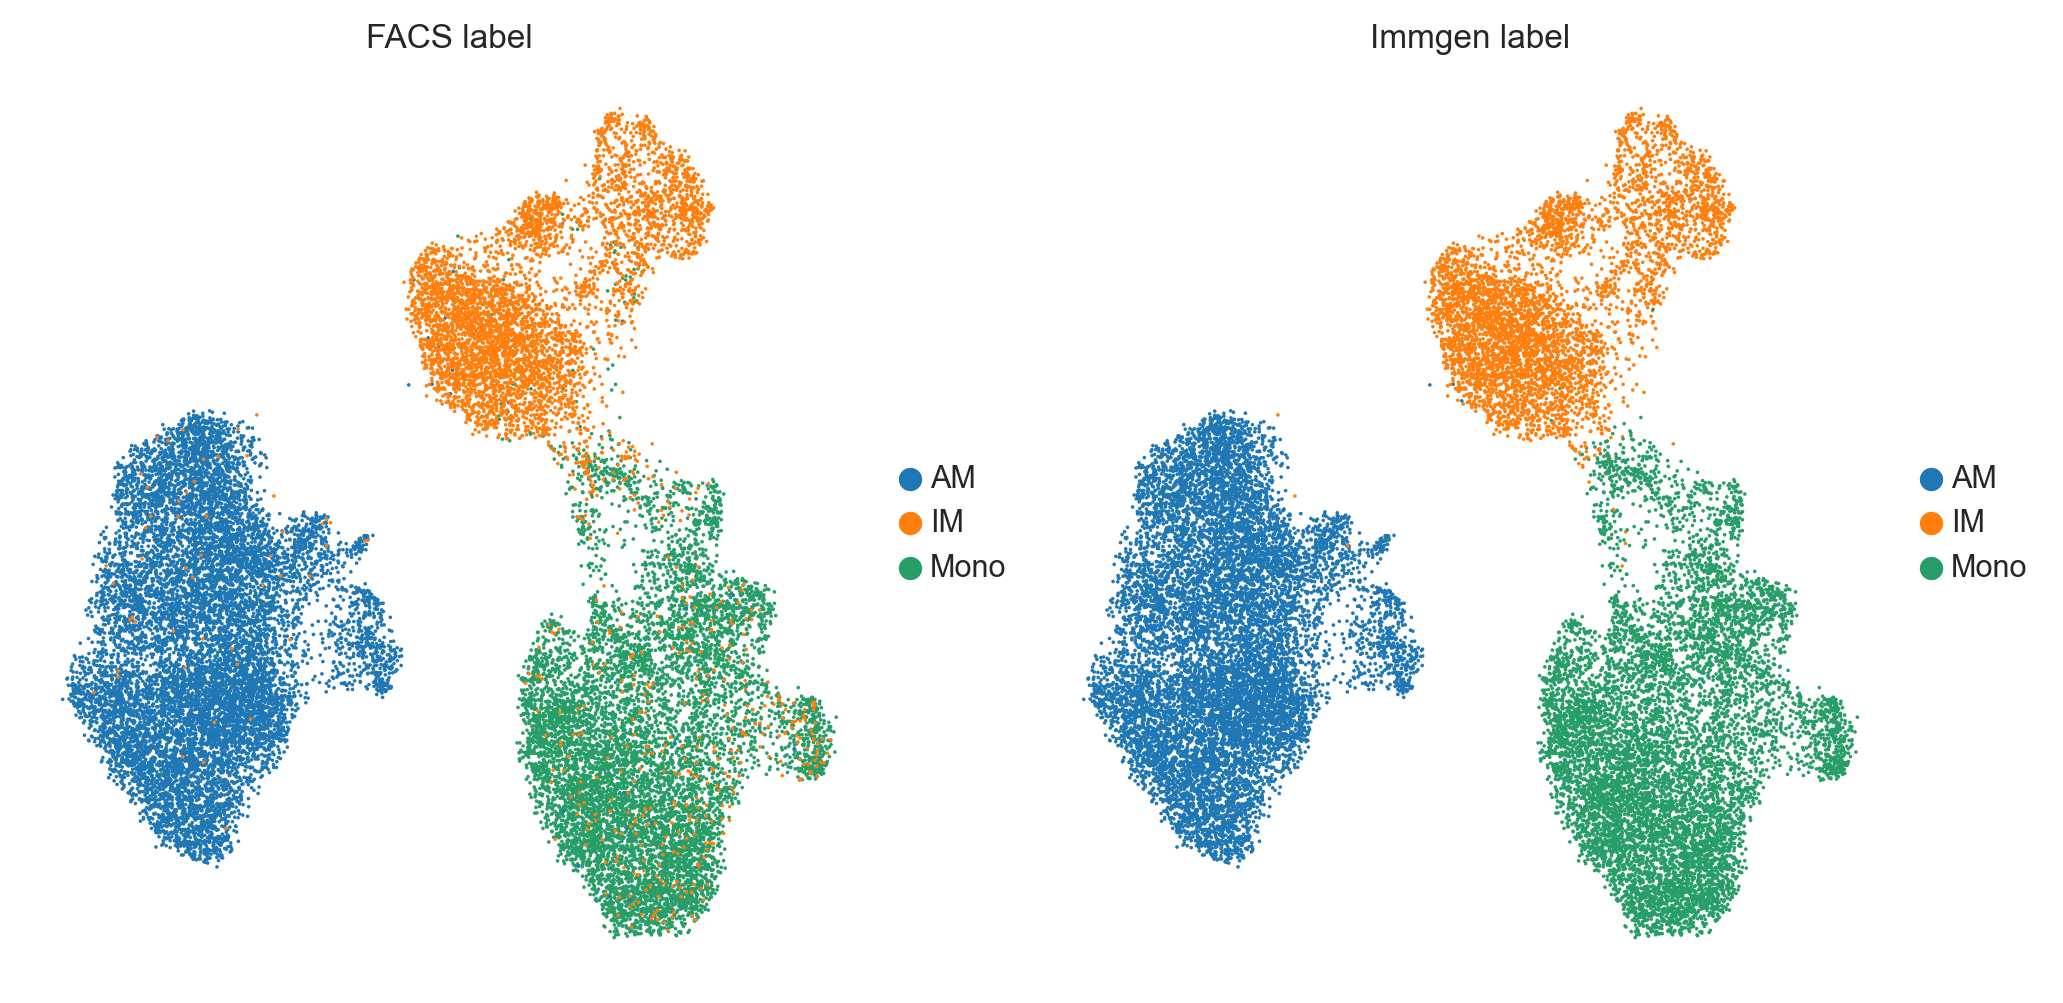

In [14]:
with plt.rc_context({"figure.figsize": (5, 4)}):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sc.pl.umap(adata, color='Cell_type', title='FACS label', show=False, ax=ax1)
    sc.pl.umap(adata, color='Cell_type_immgen', title='Immgen label', show=False, ax=ax2)

# Supplemental figure 2c

In [15]:
prot = [el for el in adata.obs.columns if 'prot' in el]
prot = [el for el in prot if 'Ig' not in el]
prot

['siglecF_prot', 'APC_prot', 'MHCII_prot', 'CD206_prot', 'Lyve1_prot']

In [16]:
for g in prot:
    adata.obs[f'MinMax_{g}'] = adata.obs[g].transform(lambda x:utils.minMax(x))

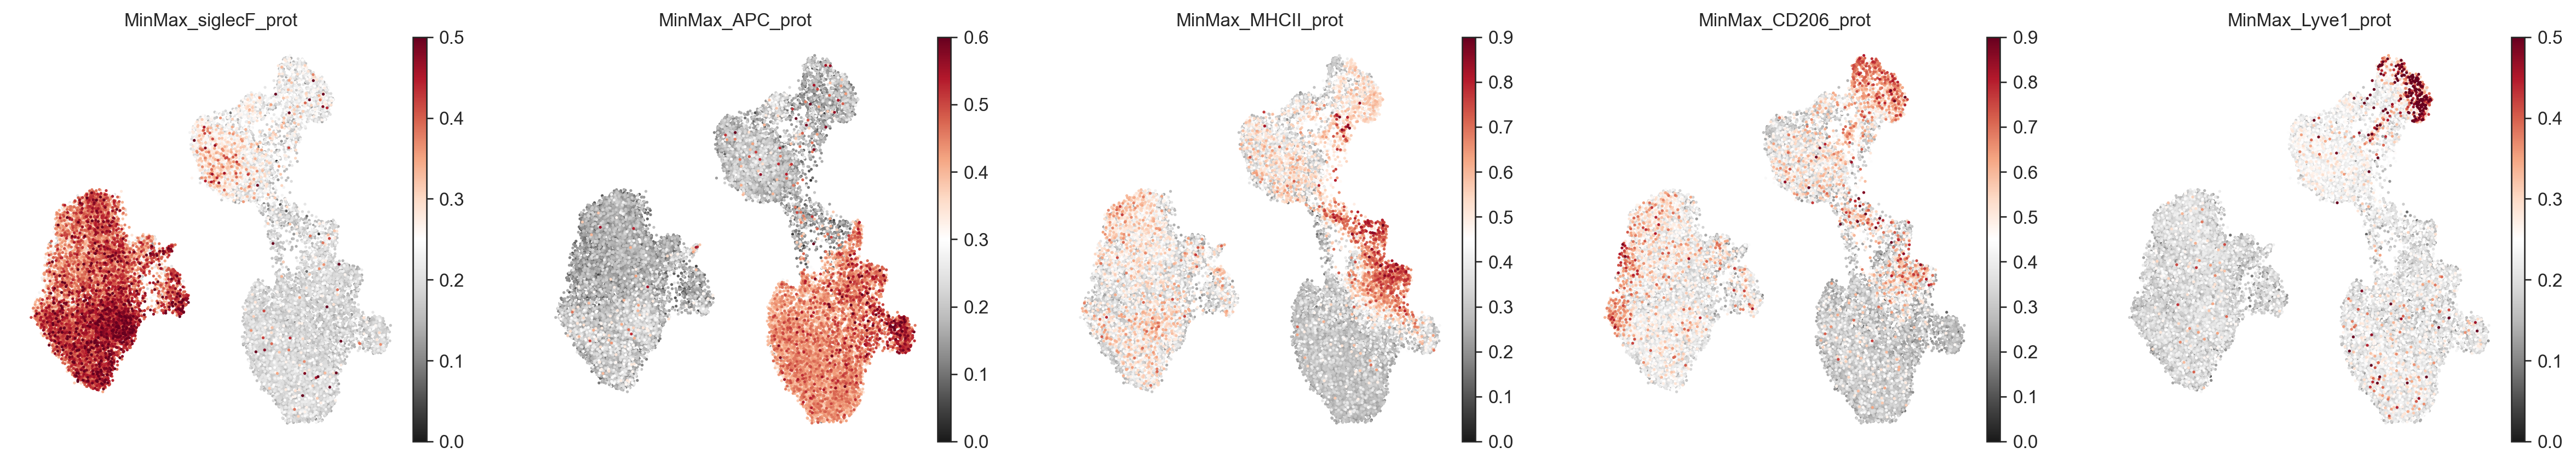

In [17]:
sc.pl.umap(adata, color=[f'MinMax_{p}' for p in prot], cmap='RdGy_r', s=10, ncols=5, vmax=[0.5, 0.6, 0.9, 0.9, 0.5])

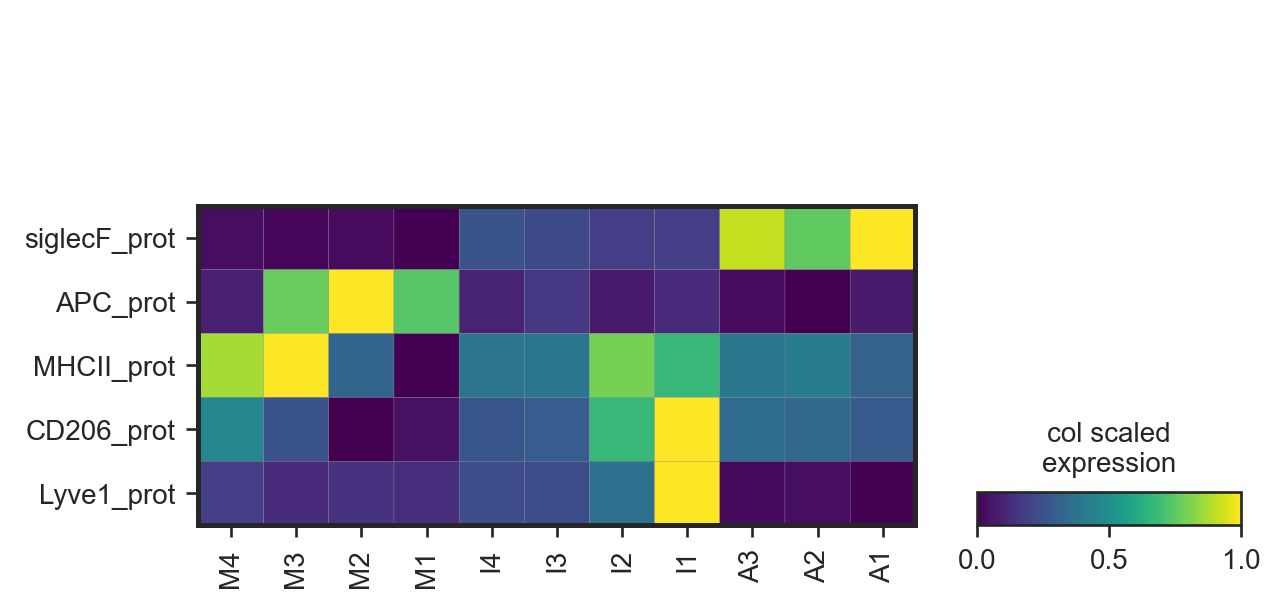

In [18]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.matrixplot(adata, var_names=prot, groupby='combined_clusters', standard_scale='var', swap_axes=True, colorbar_title='col scaled\nexpression')

# Supplemental figure 2f

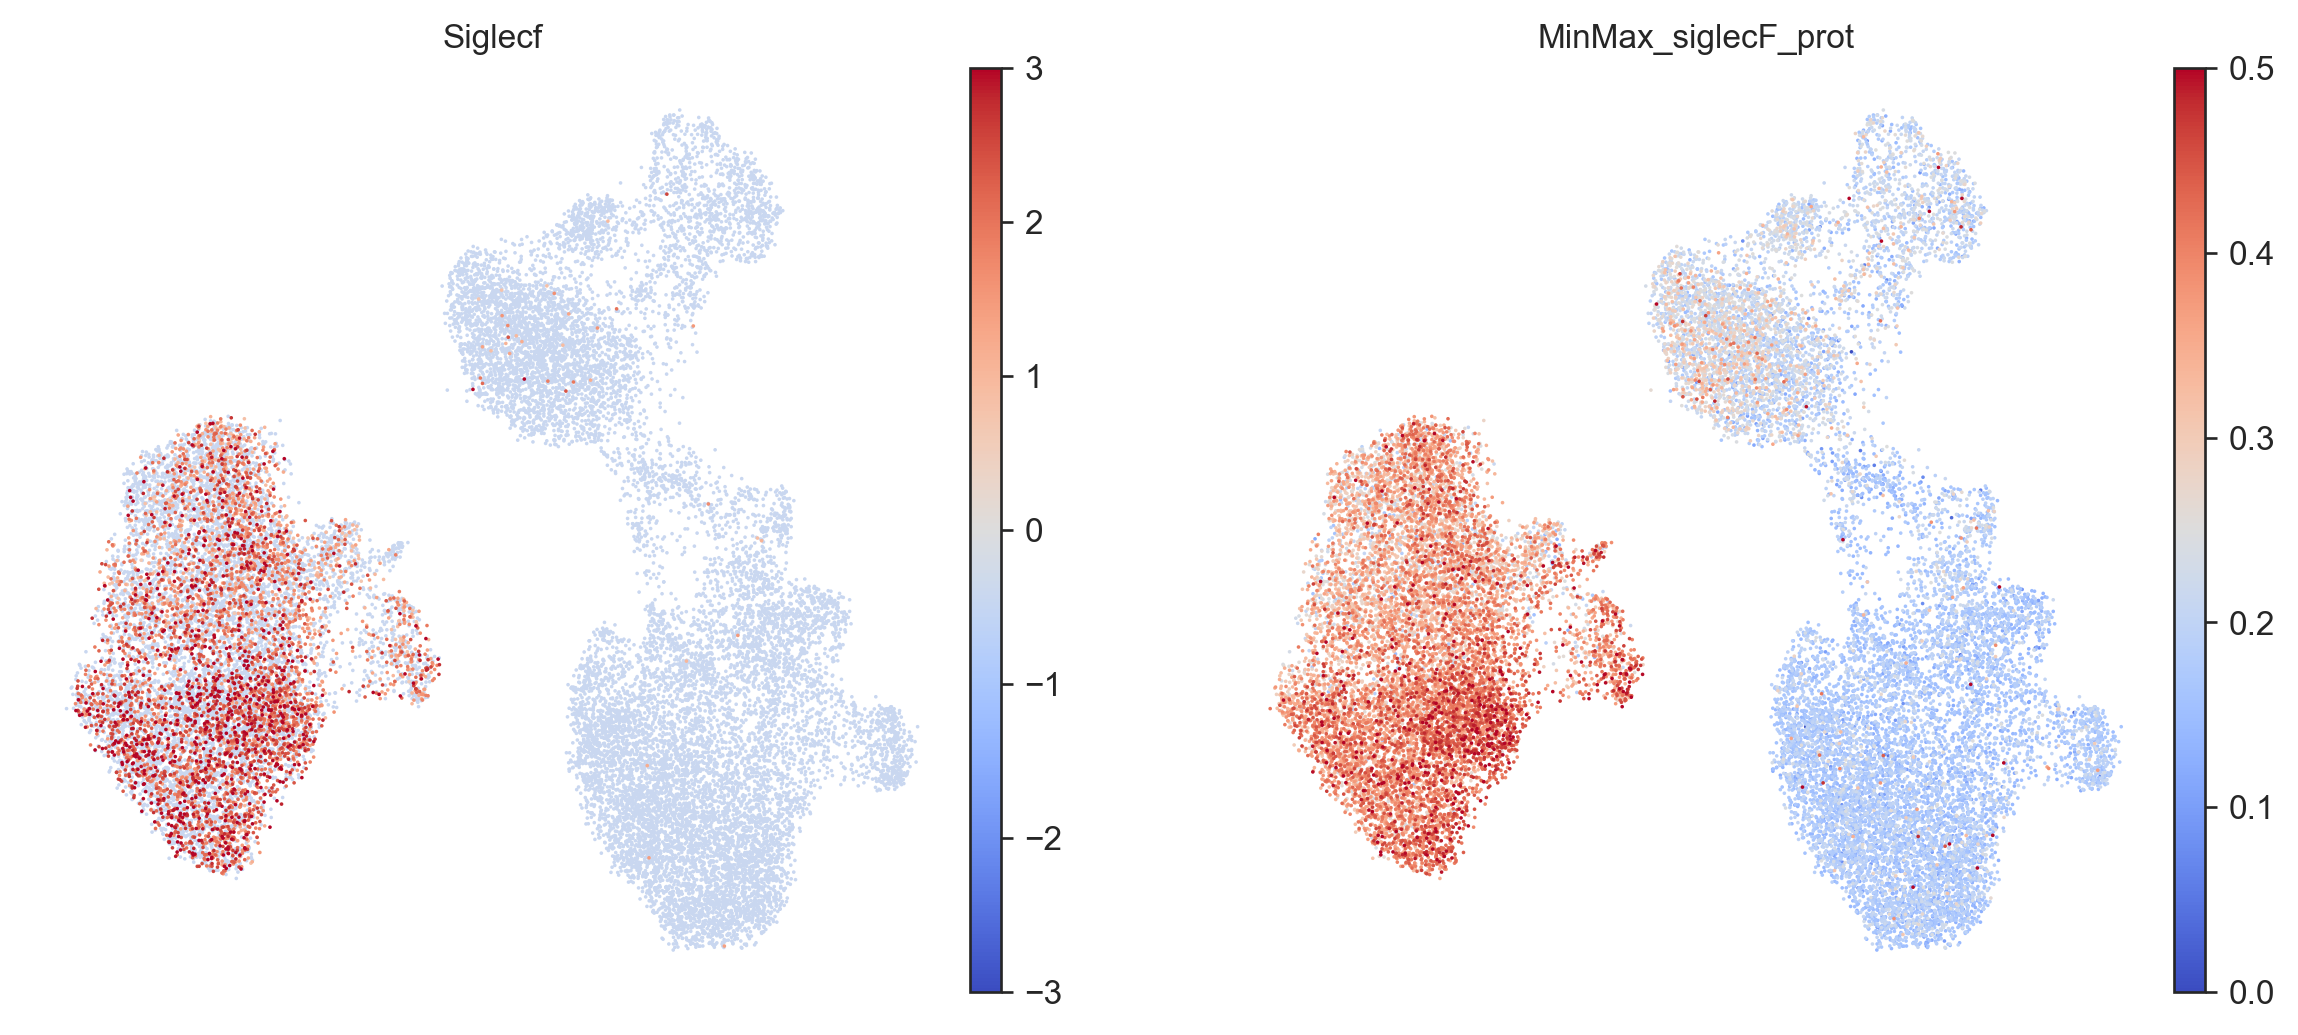

In [19]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(adata, color=['Siglecf', 'MinMax_siglecF_prot'], cmap='coolwarm', layer='scaled', vmax=[3, 0.5], vmin=[-3, 0])

# Supplemental Figure 2e

**Recover zscored expression**

In [20]:
res = pd.DataFrame(columns=adata.var_names, index=adata.obs['combined_clusters'].cat.categories) 

for clust in adata.obs.combined_clusters.cat.categories: 
    res.loc[clust] = adata[adata.obs['combined_clusters'].isin([clust]),:].layers['scaled'].mean(0)
    res = res.astype(float)

**Use zscored expression to refine markers**

In [21]:
# recover order for each cluster to improve image

order_clusters = []

for clus in markers:
    m = markers[clus]
    tmp = res[m]
    # Filter by expression
    m2 = tmp.T[[clus]]
    m2 = m2[m2>=0.7].dropna().drop_duplicates().index.tolist()
    # recover 'Lgals3', 'Cd9', 'Chil3', 'Itgax'
    if clus == 'I4':
        # Add markers that are important but get ranked lower
        m2 = m2 + ['Lgals3', 'Cd9', 'Chil3', 'Itgax']
    elif clus == 'A2':
        m2.insert(3, 'Cd63')
    tmp2 = res[m2]
    # update concise_markers
    markers[clus] = m2
    order_clusters+= utils.order_df_based_linkage(tmp2)

In [22]:
res = res[order_clusters]

In [23]:
map_genes = utils.map_genes_set(markers)
tmp = map_genes.pop('combined_clusters')
col_colors = tmp.map(cluster_colors).astype(str)

In [24]:
lens = {}
for c in ['I', 'A', 'M']:
    lens[c] = sum([len(markers[el]) for el in markers if c in el])

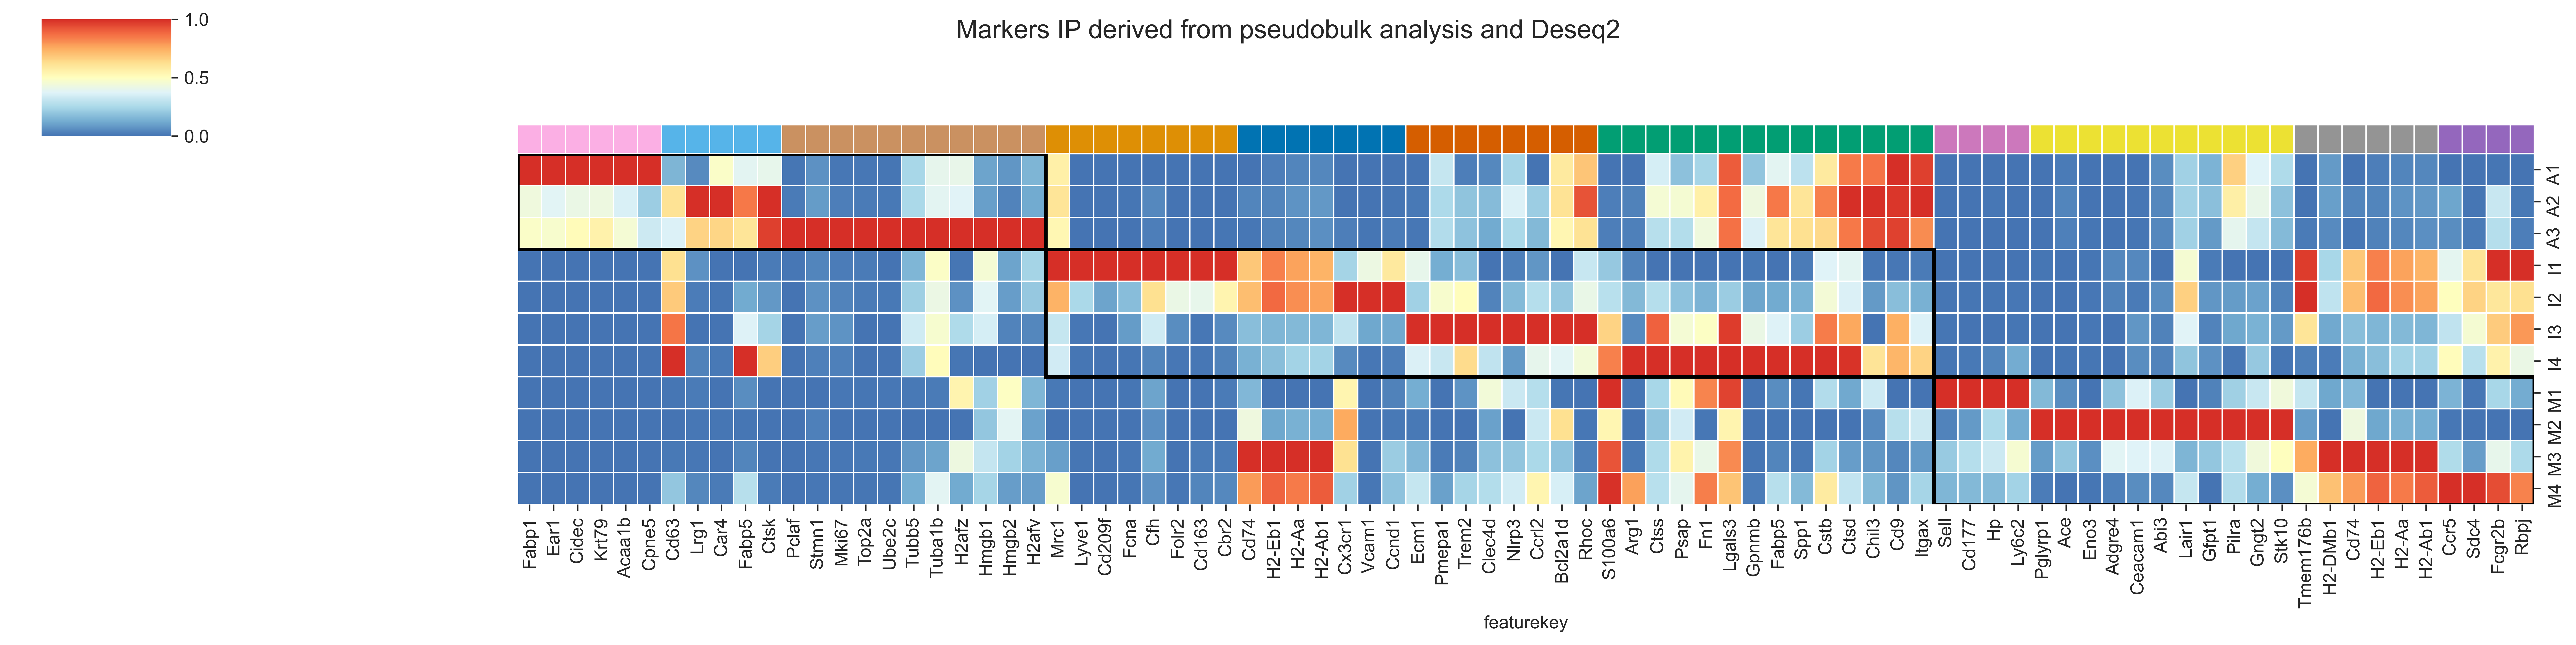

In [25]:
exp = 'IP'

with plt.rc_context({"figure.dpi": (300), "font.size" : 12}):
    f = sns.clustermap(res[::-1], figsize=(20, 5), row_cluster=False, col_cluster=False, cmap=new_cmap, standard_scale=1,
                    colors_ratio=0.06, linewidth=0.5, xticklabels=True, col_colors=col_colors.tolist())
    f.fig.suptitle(f'Markers {exp} derived from pseudobulk analysis and Deseq2')
    rect = patches.Rectangle((0, 0), lens['A'], 3, linewidth=2, edgecolor='black', facecolor='none')
    f.ax_heatmap.add_patch(rect)
    rect = patches.Rectangle((0+lens['A'], 3), lens['I'], 4, linewidth=2, edgecolor='black', facecolor='none')
    f.ax_heatmap.add_patch(rect)
    rect = patches.Rectangle((0+lens['A']+lens['I'], 7), lens['M'], 4, linewidth=2, edgecolor='black', facecolor='none')
    f.ax_heatmap.add_patch(rect)
    

# Figure 2c

In [26]:
concise_celltype = {}

for c in ['I', 'A', 'M']:
    concise_celltype[c] = {}
    for g in markers:
        if c in g:
            concise_celltype[c][g] = markers[g]

In [27]:
concise_celltype['I']['I4'] = ['Lgals3', 'Cd9'] + ['Ctss',
 'Cstb',
 'S100a6',
 'Ctsd',
 'Psap',
 'Fabp5',
 'Fn1',
 'Spp1',
 'Gpnmb',
 'Arg1',] + ['Chil3', 'Itgax']

In [28]:
#reorder
concise_celltype['M']['M3'] = ['Cd74',
 'H2-Aa',
 'H2-Eb1',
 'H2-Ab1','H2-DMb1', 'Tmem176b', 'Tmem176a',
 'Cd209a',
 'Slamf7',
 'Clec10a',
]

In [29]:
adata.obs['combined_clusters'] = adata.obs['combined_clusters'].cat.reorder_categories(new_order_clusters[::-1])

/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


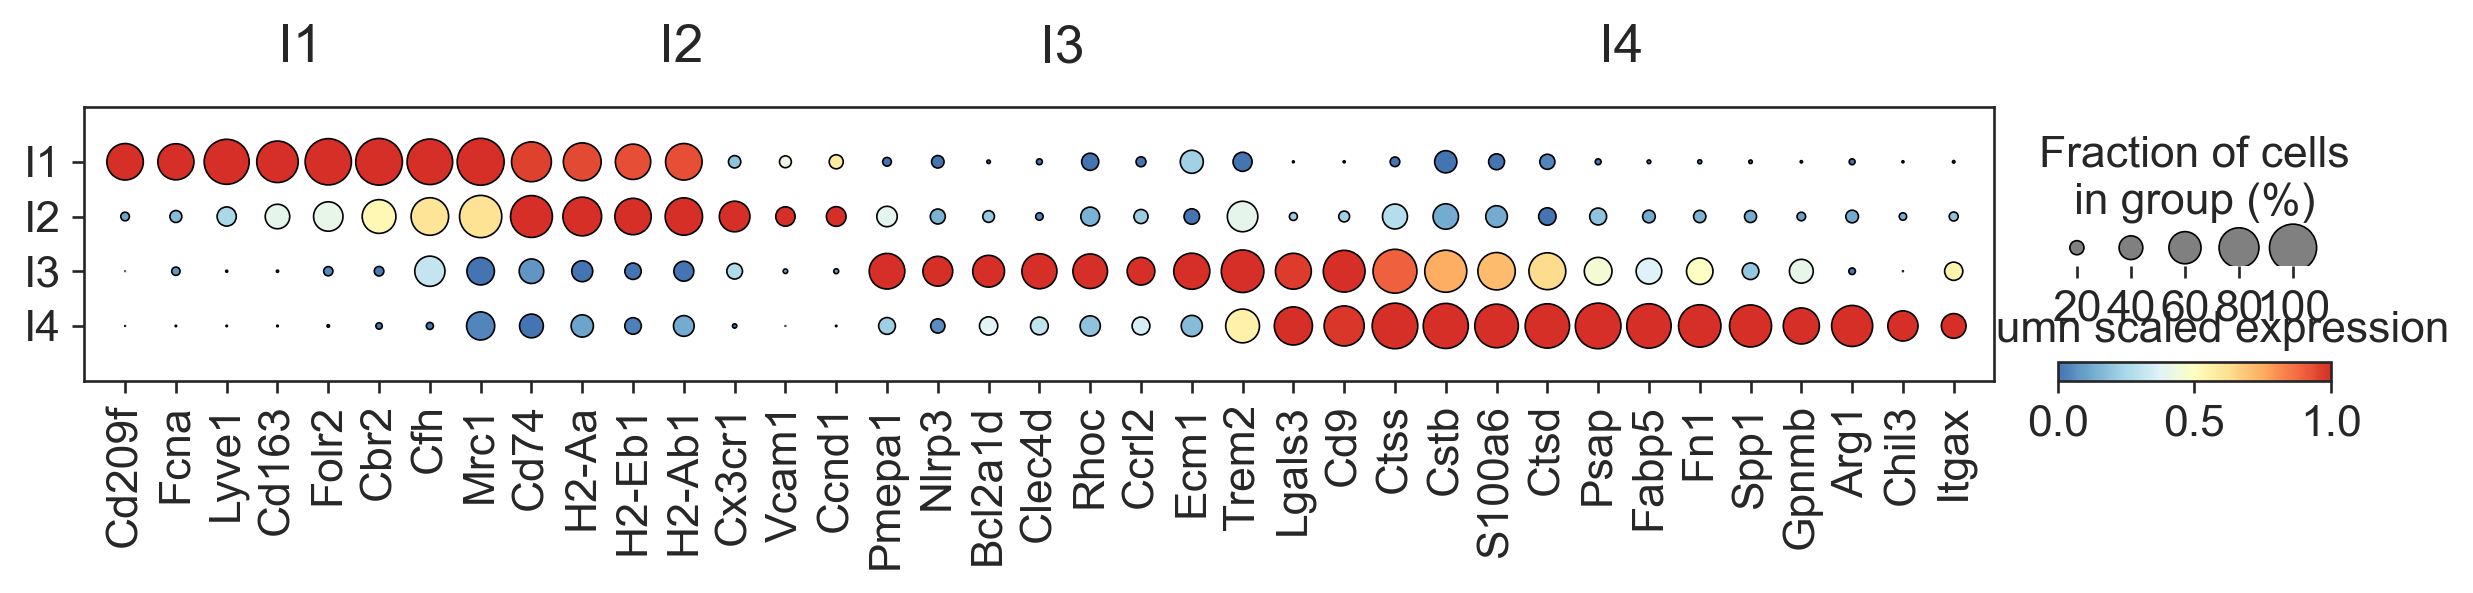

/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


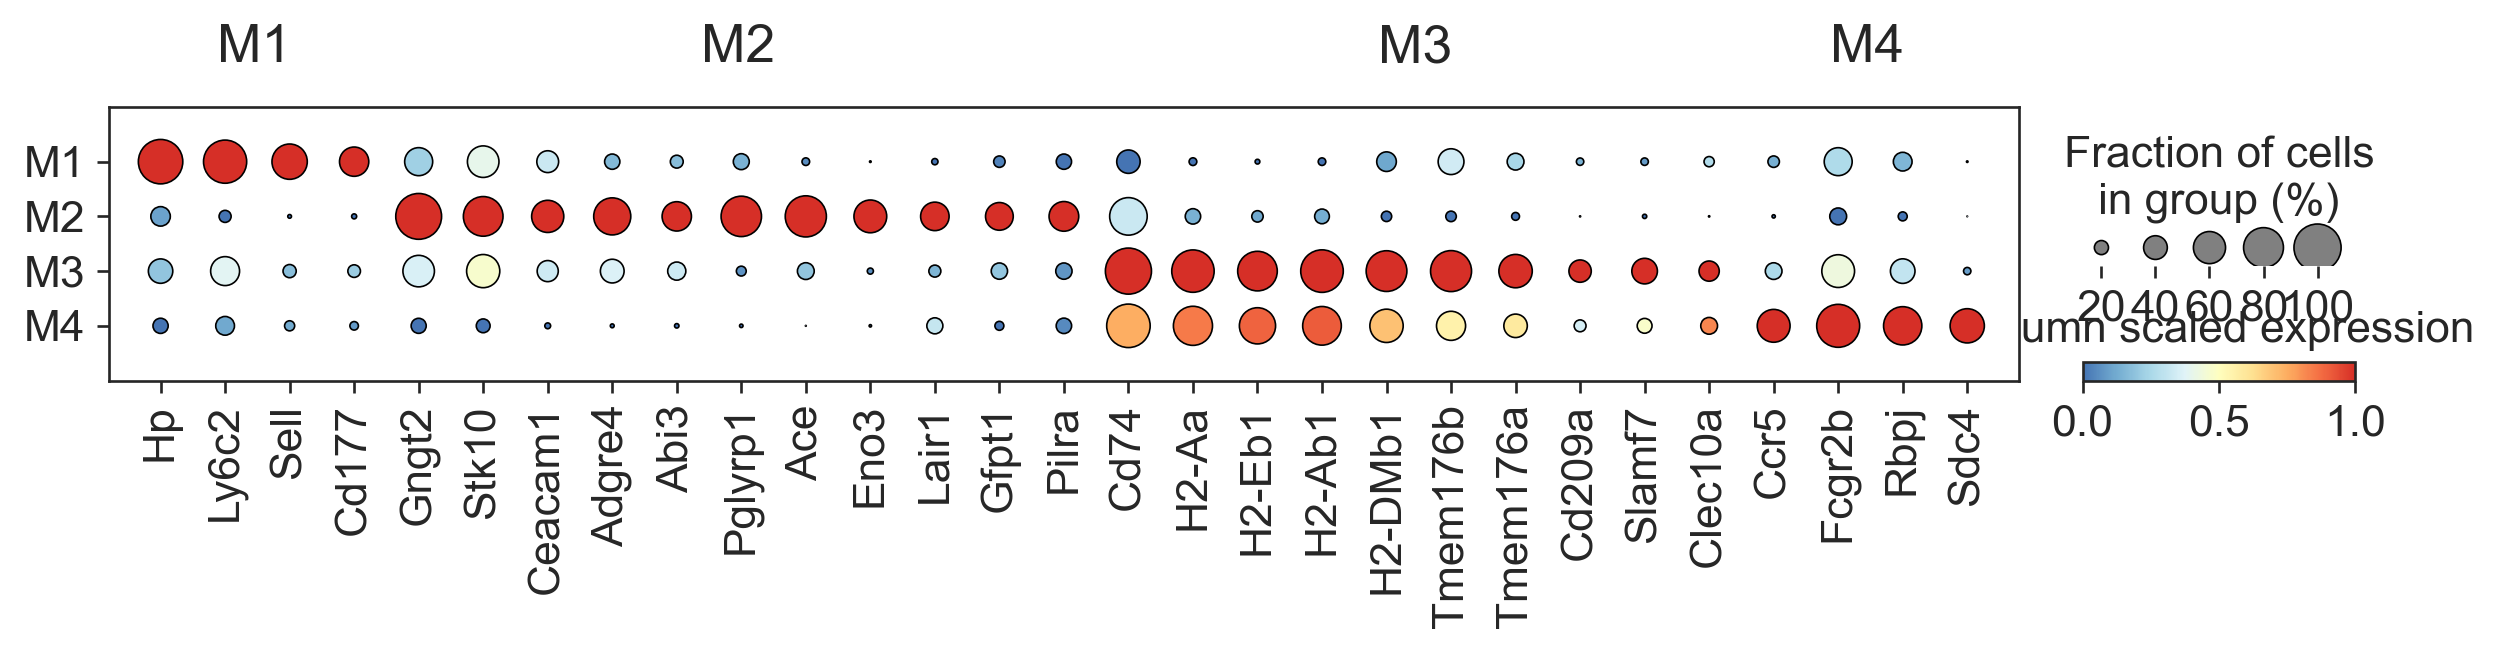

In [30]:
for c in ['I', 'M']:
    ct = c
    with plt.rc_context({"font.size" : 16}):
        sc.pl.dotplot(adata[adata.obs['combined_clusters'].isin([el for el in concise_celltype[ct]])],
                      groupby='combined_clusters', var_names=concise_celltype[ct], layer='scaled', standard_scale='var',
                      colorbar_title='column scaled expression', figsize=(12, 1.5),
                  cmap=new_cmap, linewidth=0.5)

/gstore/home/melocars/.conda/envs/mambapy38/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


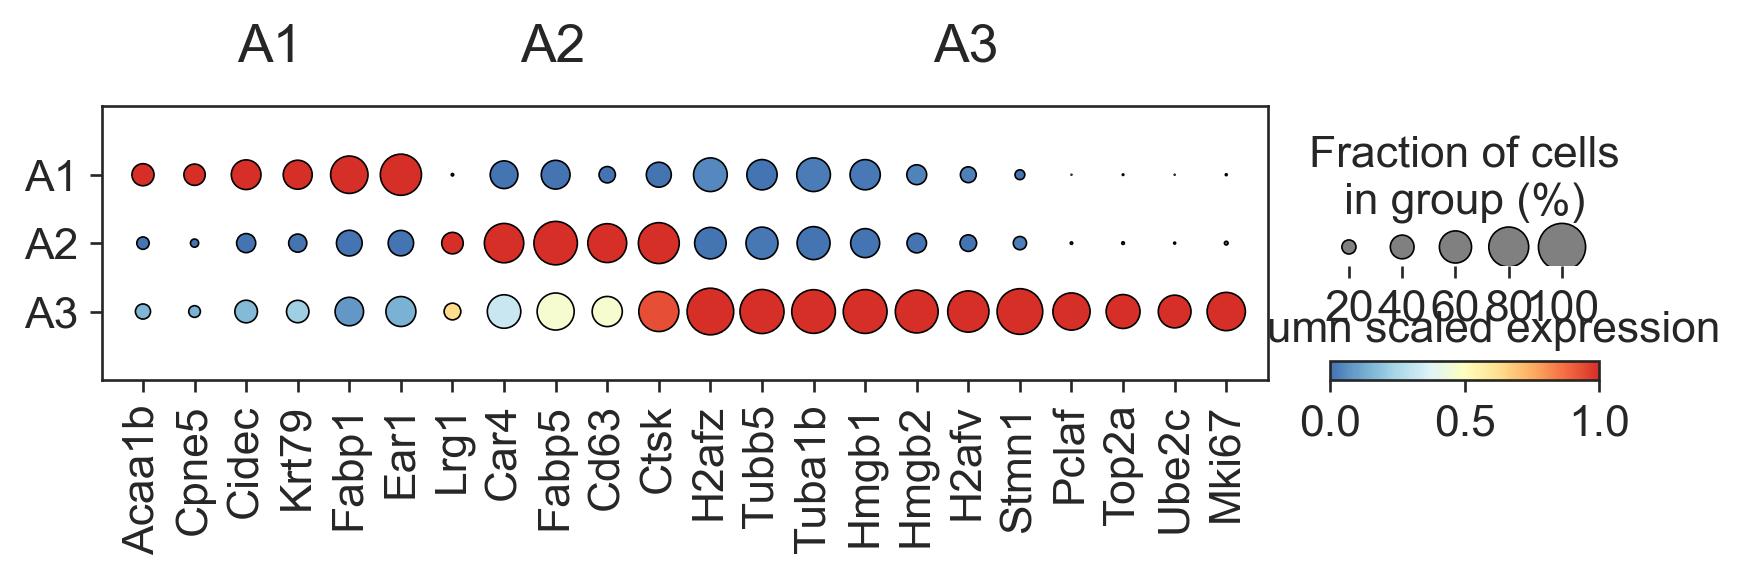

In [31]:
ct = 'A'
with plt.rc_context({"font.size" : 16}):
    sc.pl.dotplot(adata[adata.obs['combined_clusters'].isin([el for el in concise_celltype[ct]])],
              groupby='combined_clusters', var_names=concise_celltype[ct], layer='scaled', standard_scale='var',
              colorbar_title='column scaled expression', figsize=(8, 1.5),
              cmap=new_cmap, linewidth=0.5)

# Figure 2d

In [32]:
cs = utils.cosine_similarity(adata, 'combined_clusters', 'X_pca')
cs['combined_clusters'] = cs.index.to_series().apply(lambda x:x[0])
cs['combined_clusters'] = cs['combined_clusters'].map({'M':'Mono', 'I':'IM', 'A':'AM'})
celltypes = cs.pop('combined_clusters')

In [33]:
lut = {k:v for k, v in zip(adata.obs['Cell_type'].cat.categories, adata.uns['Cell_type_colors'])}
lut

{'AM': '#1f77b4', 'IM': '#ff7f0e', 'Mono': '#279e68'}

In [34]:
row_colors = celltypes.map(lut)

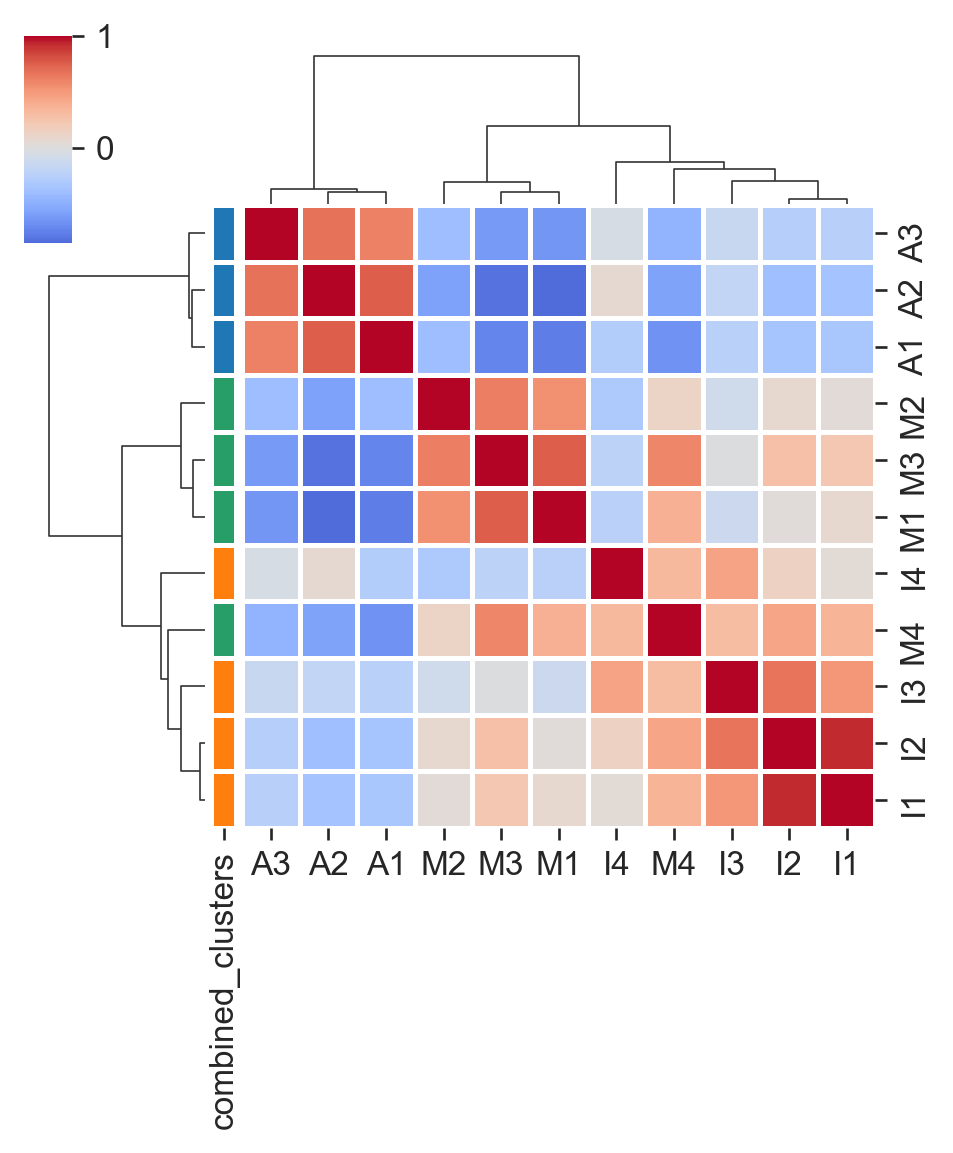

In [35]:
with plt.rc_context():
    f = sns.clustermap(cs, cmap="coolwarm", figsize=(4,4.8), linewidth=1, method='ward', center=0, row_colors=row_colors, xticklabels=True, yticklabels=True)